<a href="https://colab.research.google.com/github/iciromaco/RadiShLab/blob/master/S6_%E3%83%99%E3%82%B8%E3%82%A8%E6%9B%B2%E7%B7%9A%E3%81%82%E3%81%A6%E3%81%AF%E3%82%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# N007 中心軸の推定

In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/My Drive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
import rdlib4 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

# 左右のベジエ曲線の平均線

N006を済ませてあるなら、res フォルダに、９つの個体の左右の近似ベジエ曲線が保存されているはずなので、それを使って平均曲線を求め、表示してみよう。

In [2]:
# 予め求めてある左右分割のベジエ近似式を読み込む
fLlist = rd.loadPkl("fLlist.pkl",labhome+"/res") # 左側の近似曲線のリスト
fRlist = rd.loadPkl("fRlist.pkl",labhome+"/res") # 右側の近似曲線のリスト
imgs = rd.collectimages(NSilF)  # シルエット画像のリスト

def showAverage(num,n_samples=128):
    fl = fLlist[num]
    fr = fRlist[num]
    fc = (fl+fr)/2
    ps = np.linspace(0,1,n_samples)
    Lpoints = np.array([[int(float(fl[0].subs('t',s))),int(float(fl[1].subs('t',s)))] for s in ps])
    Rpoints = np.array([[int(float(fr[0].subs('t',s))),int(float(fr[1].subs('t',s)))] for s in ps])
    Cpoints = np.array([[int(float(fc[0].subs('t',s))),int(float(fc[1].subs('t',s)))] for s in ps])
    plt.gca().invert_yaxis() 
    plt.gca().set_aspect('equal', adjustable='box') # アスペクト比を１：１に
    plt.plot(Lpoints[:,0],Lpoints[:,1])
    plt.plot(Rpoints[:,0],Rpoints[:,1])
    plt.plot(Cpoints[:,0],Cpoints[:,1])

def showAverageAll():
    plt.figure(figsize=(10,10),dpi=75)
    for i in range(3):
        for j in range(3):
            plt.subplot(3,3,3*i+j+1)
            showAverage(3*i+j)

CPU times: user 1.94 s, sys: 4.7 ms, total: 1.95 s
Wall time: 1.95 s


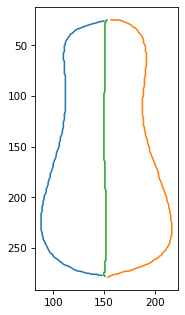

In [3]:
%%time
plt.figure(figsize=(5,5),dpi=75)
showAverage(0)

CPU times: user 1.94 s, sys: 4.18 ms, total: 1.94 s
Wall time: 1.94 s


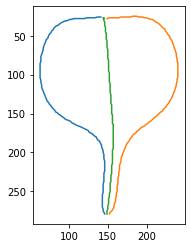

In [4]:
%%time
showAverage(1)

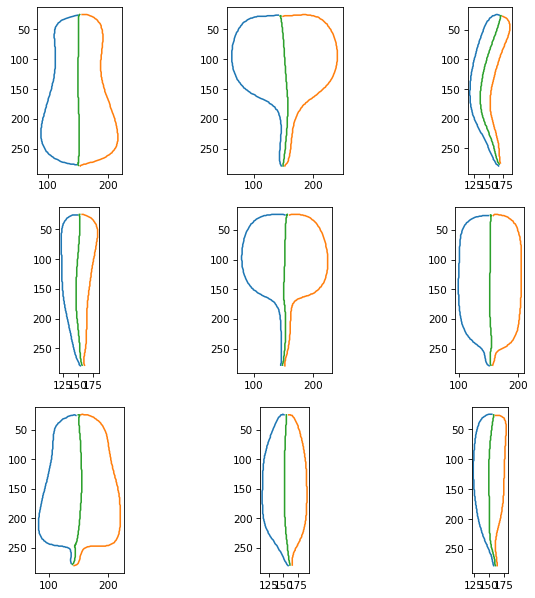

In [5]:
showAverageAll()

この９つの例に関して言えば、中心線として妥当見える。

これは左右分割が比較的成功しているからであり、上下の分割点が少しでもずれていたらこうはいかない。

また、太さの変化が激しい箇所、末端部の急激に細くなる部分は単純平均線は形状が不自然になることが多い。

例えば、左下の個体や中央右の個体でそれが顕著である。

N次ベジエ曲線の平均はやはり同じ次数の曲線となる。そもそも中心線は輪郭ほど複雑ではないはずなので、もっと次数は低くあるべきである。

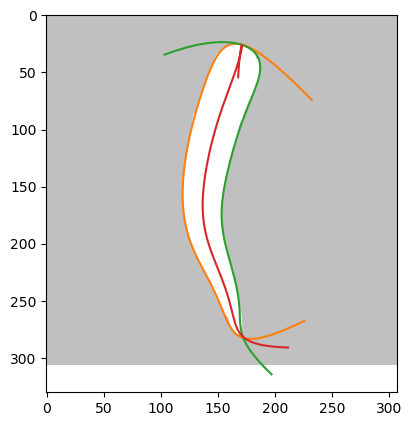

In [13]:
num = 2
img = imgs[num]
fl = fLlist[num]
fr = fRlist[num]
fc = (fl+fr)/2
rd.drawBez(img,stt=-0.1,end=1.1,bezL=fl,bezR=fr,bezC=fc,figsize=(5,5),dpi=100,ct=list("123"))

ベジエ曲線は通常パラメータ区間 [0,1] しか用いないが、あえて少し前後に延長して[-0.1,1,1]の範囲を描画してみたのが上の図である。

曲線の [0,1] から外れる部分は予想できないような伸び方をしていることがわかる。

左右の輪郭については両端点での曲線の接線は輪郭の接線とほぼ一致するような曲線となるが、その平均を使って合成した中心線は上下の両端点を過ぎたあたりで非常に複雑に変化する。

とくに上端は左右ともに延長部分が対象の輪郭に沿って回り込むような形になるのが普通なので、その場合、平均線は上端で急激にUターンするような曲線となる。

これは我々の思い描く中心線の形状とは程遠い。形状記述にとって人のイメージはどうでもよいことではあるが、記述は必要最小限に簡素化するべきであり、必要以上に高い次数を使うことに利点はない。

種や個体の特徴を捉えるという意味で、輪郭は左右２分割なら６次、全周ならば12〜14次程度で十分であると思われるが、中心線の形態については、

- ほぼ直線状
- 反りがある
- S字状
- それ以上に複雑な形状

ぐらいの識別と、その程度がわかれば十分だと思われるので、たかだか４次程度で近似するのが適当であろう。

## 曲線の次数を減らす方法

> 【方法１】左右の曲線の関数を単純に平均するとそれらと同じ次数（左右で違うなら大きい方）の次数になるので、もし中心線を４次のベジエ曲線で表したいのであれば、関数式からサンプル点を作り出して再近似すればよい。    

> 【方法２】左右の輪郭を中心で使いたい次数で近似し、その平均を中心軸の表現とする。

中心線は個体を上下に貫くような曲線がふさわしいが、４次曲線を使うならば上端はやはり急激にUターンするような曲線となるであろう。したがって、方法２を使うとしても再サンプリングが必要になるものと予想される。

また、左右の輪郭の対称性がおおきく崩れ部分については、合成曲線はいびつな形となるので整形が必要となることが予想される。どうせ後で整形するのであれば、そのもととなる曲線を得るために左右の輪郭を厳密に求めるのは時間の無駄かもしれない。

ためしに、低い次数の近似の平均曲線がどのようになるかを調べてみよう。

先の実験は予め求めておいた近似曲線を用いたが、画像からスタートして中心線の近似曲線を求めるまでのプログラムを書いてみる。なお、計算時間短縮のため、ここでは高速当てはめ、fit0() を使うことにする。

In [23]:
# 　fit0() で求めた曲線をもとに中心線を近似するプログラム
def getAverageBezline(img,N=6,n_samples=32,Amode=0,maxTry = 0):
    # img 画像
    # N ベジエ近似の次数
    # n_samples 左右輪郭線から取るサンプル点の数
    
    # 左右の輪郭を抽出
    conLeft,conRight = rd.getCntPairWithImg(img,dtopdr=1,dbtmdr=1)
    # 輪郭点を（チェインの並び順に）等間隔に n_samples 個サンプリングする。
    #左右の輪郭点をベジエ近似する
    cntL = rd.getSamples(conLeft,N=n_samples,mode='Equidistant')
    cntR = rd.getSamples(conRight,N=n_samples,mode='Equidistant')
    
    # ベジエ曲線のインスタンスを生成
    bezL = rd.BezierCurve(N=N,samples=cntL)
    bezR = rd.BezierCurve(N=N,samples=cntR)
    
    # 左右をそれぞれベジエ 曲線で近似し、その平均として中心軸を仮決定
    cpl,fL = bezL.fit0()
    cpr,fR = bezR.fit0()

    fC = (fL+fR)/2
    cpc = [x for x in (np.array(cpl)+np.array(cpr))/2]
    return cpl,cpr,cpc, fL,fR,fC,cntL,cntR

def try34(num):
    img = imgs[num]
    cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=3,n_samples=32,Amode=0)
    rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="121",figsize=(10,5),dpi=75,ct=list("123456"))
    cpl,cpr,cpc, fL,fR,fC,cntL,cntR = getAverageBezline(img,N=4,n_samples=32,Amode=0)
    rd.drawBez(img,stt=-0.10,end=1.1,bezL=fL,bezR=fR,bezC=fC,cntL=cntL,cntR=cntR,layout="122",figsize=None,ct=list("123456"))

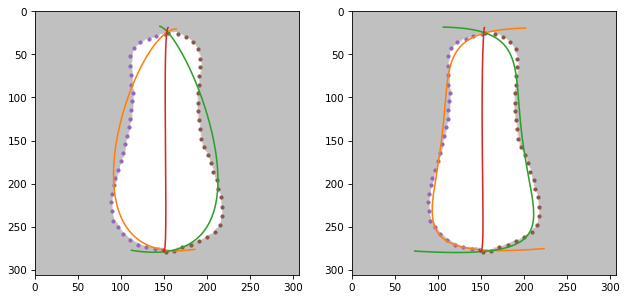

In [24]:
try34(0)

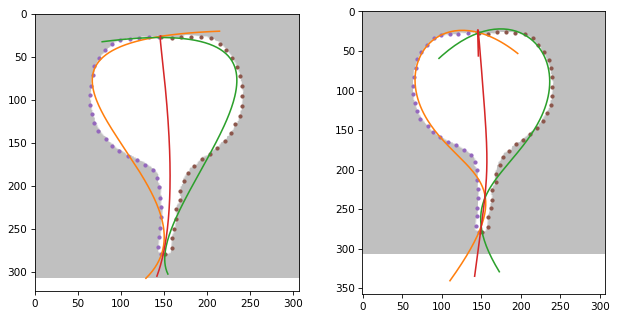

In [25]:
try34(1)

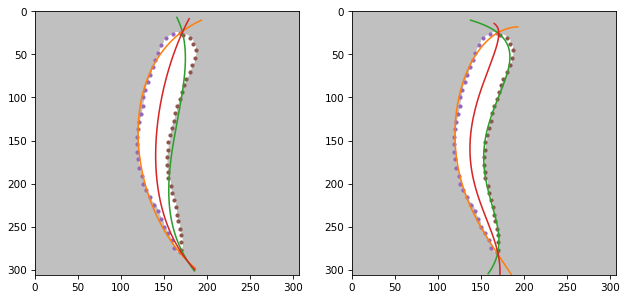

In [26]:
try34(2)

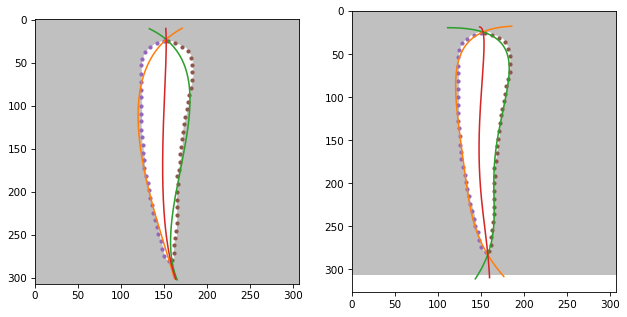

In [27]:
try34(3)

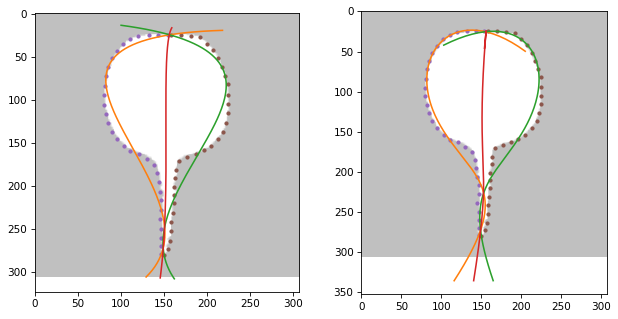

In [28]:
try34(4)

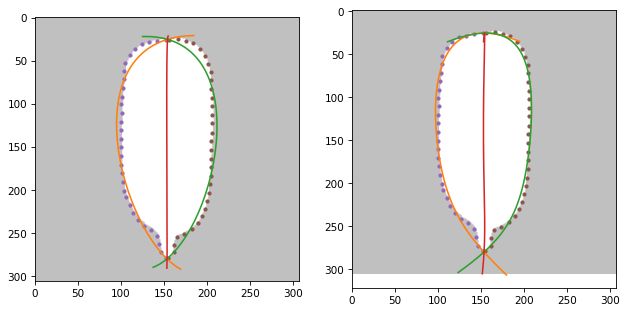

In [29]:
try34(5)

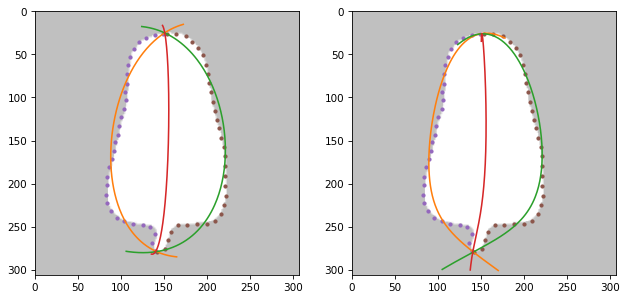

In [30]:
try34(6)

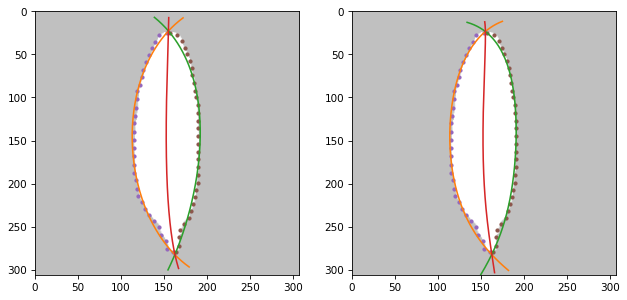

In [31]:
try34(7)

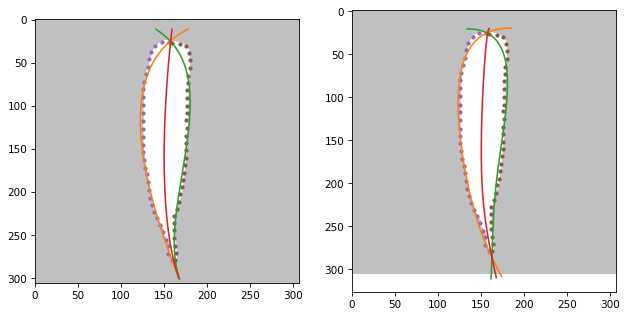

In [32]:
try34(8)

ほとんどの個体の中心軸の形状は３次近似で充分捉えられるのだが、３次と４次とでどちらが正確に形状をトレースできているかと問われると、４次に軍配を上げざるをえない。長さの計測という観点ならば、両者にそれほど差はなさそうな気はする。

# 中心軸の再近似

ここまでの実験結果を見た限りにおいては、中心線の形状記述として、４次の高速当てはめから求めた曲線も、６次以上の厳密当てはめから求めた曲線も大きな違いはなさそうである。

ただ、４次以上だと上端部分で傾きが不自然（接線が上下ではなく水平方向寄りになる）であるし、高次の近似を用いた場合は左右の形状のいびつさに影響されて合成で求めた関数まで不自然な変動が生じるので、関数式をもとにして標本点を生成した上で再近似をこころみる。

### ちょっと重要な考察
この２つの例は中心軸の近似としては十分満足できるのだが、このような肩の部分が丸みを帯びた個体の場合、上部の輪郭が少しでも内に回り込んでいると、合成で求めた中心軸のパラメトリック曲線はパラメータ０付近で急激にUターンするような形状になる。

（可能だとして）中心軸を直接近似するとすれば、そのような曲線をあてはめようとは思わないし、中心軸の点列がもし存在して曲線あてはめを行ったとしたら、やはりそのような曲線ではなく、上下に突き抜けるような曲線があてはめられるであろう。
 
 これは、ベジエ曲線のあてはめにおいて、必要以上に高い次数の曲線を用いると、同程度の誤差のあてはめは何通りも可能になってしまうということを示唆する（これは重要である）。
 
 また、そもそも「中心軸」はわれわれのイメージ、幻想でしかない。せいぜいが、対称性を見出せる個々の部分の対称軸の位置を通っていてほしい、というに過ぎず、正解がないので悩ましい。

- 軸対称の図形においてはその中心軸と一致してほしい。
- 部分的に軸対称である部分の中心を通ってほしい。
- 線対称図形の中心軸を変形してできるような図形、すなわちもとの中心軸に垂直な断面が変形前の断面に一致するような変形が加えられた図形であれば、その中心軸と一致してほしい。

　例えば、針金にウレタンゴムを巻いて作った棒を変形させてできるオブジェクトのシルエットから中心の針金の変形具合を求める、みたいな問題に取り組もうとしている。
 
 ベジエ曲線のあてはめに一意性がなければ、形状記述として意味がないかというと、そうは思わない。
 
 関数式としての記述を得ることによって、例えば曲線に沿った長さや幅を測定できたり、曲がりを補正した形状を作り出したり、といったことが可能になる。

この図形の場合、尻尾が曲がっていたために、左右の輪郭の下端の位置にずれが生じているために、平均で求めた中心軸に歪が生じており、４次の方が影響が大きい。

この歪は形状を正確にトレースしているほど顕著になる。